# Exploration of XAI on CNN model trained on the MNIST dataset

In [1]:
import torch 
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Getting the mnist data and setting up the test and train data splits

In [2]:

train_batch_size = 128
test_bach_size = 1000
random_seed = 1234

torch.manual_seed(random_seed)

In [3]:
image_transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize( (0.1307,), (0.3081,))]
    )

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    "./data/",train= True, download=True, transform= image_transform
),batch_size= train_batch_size, shuffle= True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    "./data/",train= False, download=True, transform=image_transform
),batch_size= test_bach_size, shuffle= True)

### Defining the model

In [4]:
class MNIST_Classifier(nn.Module):
    def __init__(self) -> None:
        super(MNIST_Classifier,self).__init__()
        self.conv_layer_1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv_layer_2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.linear_1 = nn.Linear(320,50)
        self.linear_2 = nn.Linear(50,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv_layer_1(x),2))
        x = F.relu(F.max_pool2d(self.dropout(self.conv_layer_2(x)),2))
        # reshaping to fit linear shape
        x = x.view(-1,320)
        x = F.relu(self.linear_1(x))
        x = F.dropout(x, training=self.training)
        x = self.linear_2(x)

        return F.log_softmax(x,dim=1)

### Setting the hyper parameter

In [5]:
learning_rate = 0.01
momentum = 0.5
log_interval = 10
epochs = 3

### Optimizer setup

In [6]:
network = MNIST_Classifier()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [7]:
def test(network,test_loader):
    network.eval()
    test_loss_total = 0
    no_of_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                network.cuda()
                data = data.cuda()
                target = target.cuda()
            output = network(data)
            test_loss_total += F.nll_loss(output, target, reduction='sum').item()
            prediction = output.data.max(1, keepdim=True)[1]
            no_of_correct += prediction.eq(target.data.view_as(prediction)).sum()
        test_loss_total /= len(test_loader.dataset)
        print("Test: avg loss: {:.6f} accuracy {}/{} percentage {:.1f}".format(test_loss_total,
        no_of_correct,len(test_loader.dataset),  100 * (no_of_correct/len(test_loader.dataset))))

    return test_loss_total

In [8]:
def train(epoch,interval,network,optimizer,data_loader,test_loader=test_loader):
    # Setting the network to training mode
    training_loss_current_min = 0 
    for batch_no, (data, target) in enumerate(data_loader):
        network.train()
        optimizer.zero_grad()
        # Moving the elements to the gpu
        if torch.cuda.is_available():
            network.cuda()
            data = data.cuda()
            target = target.cuda()
        
        output = network(data)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        # setting the loss in the first iteration
        if batch_no % interval == 0:
            print('Training: {} : {:.1f} : Loss :{:.6f}'.format(epoch,
            100. * batch_no / len(data_loader), loss.item()))
            test_loss = test(network=network,test_loader=test_loader)
            if training_loss_current_min == 0:
                training_loss_current_min = test_loss
            if training_loss_current_min > test_loss:
                print('The current min {:.6f} new min {:.6f} saving...'.format(training_loss_current_min,test_loss))
                torch.save(network.state_dict(),"./result/model.pth")
                training_loss_current_min = test_loss

In [9]:
test(network=network,test_loader=test_loader)
for e in range(1, epochs+1):
    train(epoch=e,interval=log_interval,network=network,optimizer=optimizer, data_loader=train_loader)

Test: avg loss: 2.309193 accuracy 1034/10000 percentage 10.3
Training: 1 : 0.0 : Loss :2.297200
Test: avg loss: 2.308351 accuracy 1036/10000 percentage 10.4
Training: 1 : 2.1 : Loss :2.318082
Test: avg loss: 2.295337 accuracy 1234/10000 percentage 12.3
The current min 2.308351 new min 2.295337 saving...
Training: 1 : 4.3 : Loss :2.308035
Test: avg loss: 2.283520 accuracy 1706/10000 percentage 17.1
The current min 2.295337 new min 2.283520 saving...
Training: 1 : 6.4 : Loss :2.270305
Test: avg loss: 2.272605 accuracy 1870/10000 percentage 18.7
The current min 2.283520 new min 2.272605 saving...
Training: 1 : 8.5 : Loss :2.258447
Test: avg loss: 2.259065 accuracy 2032/10000 percentage 20.3
The current min 2.272605 new min 2.259065 saving...
Training: 1 : 10.7 : Loss :2.251665
Test: avg loss: 2.242946 accuracy 2340/10000 percentage 23.4
The current min 2.259065 new min 2.242946 saving...
Training: 1 : 12.8 : Loss :2.229795
Test: avg loss: 2.222235 accuracy 3272/10000 percentage 32.7
The c

In [10]:
network.load_state_dict(torch.load("./result/model.pth"))
test(network=network,test_loader=test_loader)

Test: avg loss: 0.153764 accuracy 9523/10000 percentage 95.2


0.1537640869140625

In [11]:
example_size = 10
tests = enumerate(test_loader)
batch , (example_data,example_values) = next(tests)
example_data = example_data[:example_size] 
example_values = example_values[:example_size]
example_data.shape

torch.Size([10, 1, 28, 28])

In [13]:
network = network.cpu()

In [14]:
noisy_examples = example_data / 2 +  torch.rand(1,28,28) + torch.rand(1,28,28) + torch.rand(1,28,28)
noisy_examples.shape

torch.Size([10, 1, 28, 28])

In [16]:
from captum.attr import IntegratedGradients

In [17]:
ig = IntegratedGradients(network)


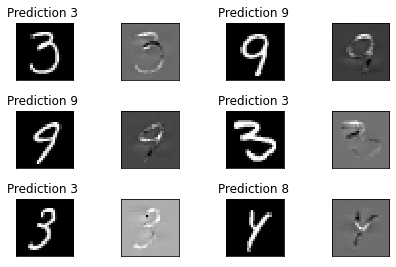

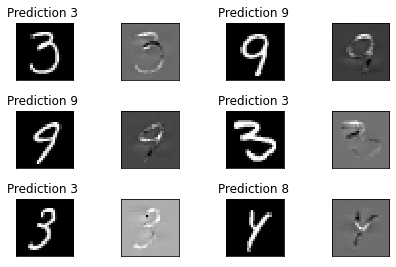

In [37]:
baseline = torch.zeros(1,1,28,28)

fig = plt.figure()
position = 1
with torch.no_grad():
    for i in range(6):
        attributions, attributions_error = ig.attribute(inputs=example_data[i],baselines=baseline, target=example_values[i],
                         method='gausslegendre', return_convergence_delta=True)
        plt.subplot(3,4,position)
        position += 1
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        output = network(example_data[i])
        plt.title("Prediction {} ".format(output.data.max(1)[1].item()))
        plt.xticks([])
        plt.yticks([])

        plt.subplot(3,4,position)
        position += 1
        plt.tight_layout()
        plt.imshow(attributions[0][0], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
fig                                    

In [38]:
fig.savefig("proper_inputs.png", format='PNG')

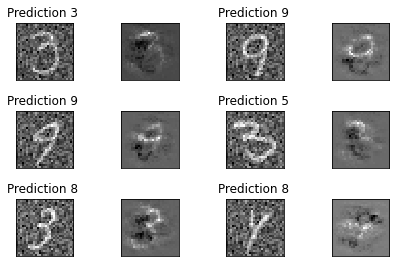

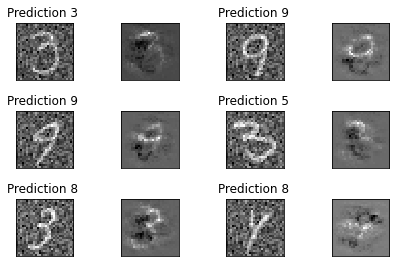

In [41]:
fig = plt.figure()
position = 1
with torch.no_grad():
    for i in range(6):
        attributions, attributions_error = ig.attribute(inputs=noisy_examples[i],baselines=baseline, target=example_values[i],
                         method='gausslegendre', return_convergence_delta=True)
        plt.subplot(3,4,position)
        position += 1
        plt.tight_layout()
        plt.imshow(noisy_examples[i][0], cmap='gray', interpolation='none')
        output = network(noisy_examples[i])
        plt.title("Prediction {} ".format(output.data.max(1)[1].item()))
        plt.xticks([])
        plt.yticks([])

        plt.subplot(3,4,position)
        position += 1
        plt.tight_layout()
        plt.imshow(attributions[0][0], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
fig                      

In [40]:
fig.savefig("noisy_inputs.png", format='PNG')